In [1]:
%matplotlib inline

In [2]:
import redqueen.opt_model as OM
import redqueen.opt_runs as OR
import redqueen.utils as RU
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import decorated_options as Deco
import multiprocessing as MP

In [3]:
sns.set_style(style='dark')
sns.set_palette('Set2')

In [4]:
from importlib import reload
reload(OM)
reload(OR)
reload(RU)

<module 'redqueen.utils' from '/Users/musically_ut/prog/work/RedQueen/redqueen/utils.py'>

In [5]:
OR.SimOpts(**{
        'src_id': 1,
        'q_vec': [],
        's': 1.0,
        'other_sources': [
            (
                'Poisson', 
                {
                    'src_id': 2,
                    'seed': 42,
                    'rates': 100
                }
            )
        ],
        'sink_ids': [1001],
        'end_time': 100.0,
        'edge_list': [(1, 1001), (2, 1001)]
    })

In [6]:
simOpts = OR.SimOpts.std_poisson(42, 1000)

# Exponential sampler

The output intensity is given by:

$$
u(t) = \exp( \underbrace{W_h \cdot h_j}_{\text{past}} - \overbrace{W_t (t - t_j)}^{\text{decay}} + \underbrace{b_t}_{\text{base}} )
$$

where $t_j$ is the last event before $t$.

It is simplified to the following in the code:

$$
u(t) = c \cdot e^{- W_t \cdot (t - t_j)}
$$

In [7]:
%run -i tpprl/exp_sampler.py

Testing the sampler.

In [8]:
def_plot_opts = Deco.Options(vt=0.5, 
                             wt=1.0,
                             bt=1.0,
                             init_h=0,
                             t_min=0,
                             t_max=10,
                             resolution=200)

@Deco.optioned()
def plot_lambda(vt, wt, bt, init_h, t_min, t_max, events, resolution):
    X = np.linspace(t_min, t_max, num=resolution)
    
    
    event_idx = 0
    c = np.exp(vt * init_h + bt)
    t0 = t_min
    
    # TODO: In the baseilne, shouldn't the t_0 still be updated to the latest event?
    Y1 = [c * np.exp(-wt * (x - t0)) for x in X]
    
    Y2 = [None] * len(X)
    for idx, x in enumerate(X):
        while event_idx < len(events) and events[event_idx][0] < x:
            c = np.exp(vt * events[event_idx][1] + bt)
            t0 = events[event_idx][0]
            event_idx += 1
            
        Y2[idx] = c * np.exp(-wt * (x - t0))
    
    plt.step(X, Y1, '--', label='Baseline')
    plt.step(X, Y2, '-', label='Correct')
    plt.vlines([x[0] for x in events], ymin=0, ymax=max(Y2), label='Events')
    plt.legend()
    return (X, Y1, Y2)

In [9]:
events = [(1, -8), (5, 5), (9, 0)]

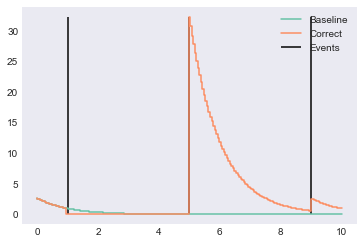

In [10]:
X, Y1, Y2 = plot_lambda(events=events, _opts=def_plot_opts)

In [11]:
sampler = ExpCDFSampler(_opts=def_plot_opts, seed=101 + 1279)

In [12]:
sampler.generate_sample()

0.6092880541958573

In [13]:
sampler.reset_only_sample(sampler.generate_sample())

0.98369540000156641

In [14]:
sampler.reset(1, -4, False)

0.9725887021550208

In [16]:
sampler.register_event(5, 0.5, False)

4.924794439657469

In [17]:
sampler.reset_only_sample(sampler.generate_sample())

4.9482122321618336

In [18]:
sampler.register_event(9, 0, False)

8.7893001591946209

In [19]:
sampler.reset_only_sample(sampler.generate_sample())

9.0386156318159898

In [20]:
sampler.generate_sample()

9.0386156318159898

## Tests

In [13]:
%%time
all_sim_events = []
processes = None
N = 10000
verbose = False

assert not verbose or (N < 10 and processes is not None), "Cannot have verbose output with these settings."

def worker_sampler(params):
    ii, sampler = params
    event_idx = 0
    next_sample = sampler.generate_sample()
    sim_events = []
        
    while next_sample < def_plot_opts.t_max or event_idx < len(events):
        while event_idx < len(events) and \
              events[event_idx][0] < next_sample:
            # print("Old = ", next_sample)
            old_sample = next_sample
            next_sample = sampler.register_event(events[event_idx][0], 
                                                 events[event_idx][1], 
                                                 False)
            if verbose:
                print("Eps = {}, Old = {}, Event = {}, Next = {}"
                      .format(ii, old_sample, events[event_idx], next_sample))
                
            event_idx += 1
            
        if next_sample > def_plot_opts.t_max:
            break
            
        if verbose:
            print("Final sample = {}".format(next_sample))                
        
        sim_events.append(next_sample)
        next_sample = sampler.reset_only_sample(next_sample)
    
    return sim_events
    

with MP.Pool(processes=processes) as pool:
    for sim_events in pool.map(worker_sampler,
                               [(ii, ExpCDFSampler(_opts=def_plot_opts, seed=101 + ii))
                                for ii in range(N)]):
        all_sim_events.append(sim_events)


CPU times: user 1.27 s, sys: 228 ms, total: 1.49 s
Wall time: 4.5 s


In [14]:
flat_events = [x for y in all_sim_events for x in y]

In [15]:
[x for x in flat_events if x < 0]

[]

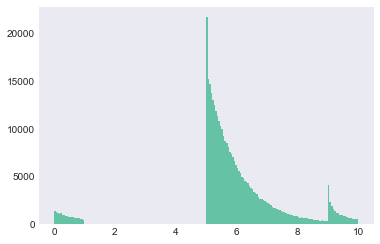

In [16]:
plt.hist(flat_events, bins=200);

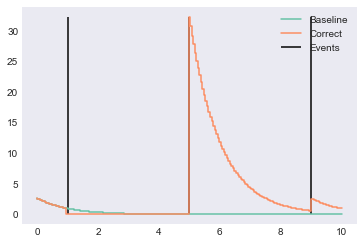

In [17]:
X, Y1, Y2 = plot_lambda(events=events, _opts=def_plot_opts)

In [43]:
len(all_sim_events)

10

## Multi-dimensional hidden state

## ExpCDFBroadcaster

In [15]:
class ExpBroadcasterOld(OM.Broadcaster):
    
    @Deco.optioned()
    def __init__(self, src_id, seed, vt, wt, bt, init_h, t_min=0):
        super(ExpBroadcasterOld, self).__init__(src_id, seed)
        self.init = False
        self.vt = vt
        self.wt = wt
        self.bt = bt
        self.init_h = init_h
        self.exp_sampler = ExpCDFSampler(vt=vt, wt=wt, bt=bt,
                                         init_h=init_h, t_min=t_min, seed=seed)
        
    def get_next_interval(self, event):
        if not self.init:
            self.init = True
            # Nothing special to do for the first event.
            
        self.state.apply_event(event)
        
        if event is None:
            # This is the first event. Post immediately to join the party?
            # Or hold off?
            return self.exp_sampler.generate_sample()
        elif event.src_id == self.src_id:
            # We posted.
            hidden_state = self.exp_sampler.get_last_hidden_state()
            new_hidden_state = self.random_state.randn(*hidden_state.shape)
            self.exp_sampler.register_event(time=self.get_current_time(event), 
                                            new_h=hidden_state,
                                            own_event=True)
        else:
            # Have to update the hidden state and the t0 of our ExpSampler
            return None # Preserve the old time

In [16]:
OM.SimOpts.registerSource('ExpBroadcasterOld', ExpBroadcasterOld)

In [17]:
RS = np.random.RandomState(420)

simOpts = OM.SimOpts(
   src_id = 1,
   end_time = 100, # When the simulations stop
   q_vec = np.asarray([1.0, 1.0]), # Weights of followers
   s = 1.0, # Control parameter for RedQueen
   sink_ids = [1, 2],
   other_sources = [
      ('ExpBroadcasterOld', 
       {'src_id': 2,
        'seed': 42,
        'wt': 0.5,
        'init_h': 0.1 * RS.randn(10),
        'vt': 0.1 * RS.randn(10),
        'bt': 1.0,
       }
      ),
      ('Hawkes',
       {'src_id': 3,
        'seed': 43,
        'alpha': 0.01 * np.exp(RS.randn(10).dot(RS.randn(10))),
        'beta': 0.5,
        'l_0': np.exp(1.0)
       }
      )
   ],
   edge_list=[(1, 1), (1, 2), 
              (2, 1), (2, 2),
              (3, 1), (3, 2)]
)

In [18]:
mgr = simOpts.create_manager_with_opt(seed=6)

In [19]:
%%time
mgr.run_dynamic()

CPU times: user 124 ms, sys: 3.73 ms, total: 128 ms
Wall time: 129 ms


In [20]:
df = mgr.get_state().get_dataframe()

In [21]:
df.head()

,event_id,sink_id,src_id,t,time_delta
0,100,1,1,0.000000,0.000000
1,100,2,1,0.000000,0.000000
2,101,1,3,0.044966,0.044966
3,101,2,3,0.044966,0.044966
4,102,1,3,0.097634,0.052668


In [22]:
df.groupby('src_id').size()

src_id
1     614
2    1174
3     520
dtype: int64

# Reinf broadcaster

In [23]:
iterSession = tf.InteractiveSession()

In [96]:
iterSession.run(tf.one_hot([0,1], depth=1, dtype=tf.float32))

RuntimeError: Graph is finalized and cannot be modified.

In [97]:
input_dim = 1
hidden_dim = 16

class ReinfNetwork():
    def __init__(self, s_size, scope, trainer):
        with tf.variable_scope(scope):
            self.event_source = tf.placeholder(dtype=tf.int64, name='Event source', shape=[1])
            self.inp = tf.one_hot(indices=[self.event_source], depth=1, dtype=tf.float32)
            self.cell = tf.contrib.rnn.BasicRNNCell(hidden_dim)
            self.Wh = tf.get_variable('Wh', shape=)            

SyntaxError: invalid syntax (<ipython-input-97-5ada64ef1d8c>, line 10)

In [25]:
class Reinf(OM.Broadcaster):
    
    @Deco.optioned()
    def __init__(self, src_id, seed, hidden_dim):
        super(Reinf, self).__init__(src_id, seed)
        self.init = False
        
        self.Wh = tf.get_variable()
        
    def get_next_interval(self, event):
        if not self.init:
            # Create variables here?
            self.init = True
        
        self.state.apply_event(event)
        
        if event is None:
            # This is the first event. Post immediately to join the party?
            # Or hold off?
            return np.inf
        
        elif event.src_id == self.src_id:
            # We posted. Calculate reward.
            # We would never like to post now.
            return np.inf
        
        else:
            # Update our rate of posting.
            r_t = self.state.get_wall_rank(self.src_id, self.sink_ids,
                                           dict_form=False)
            # TODO: Magic.
            #  1 - Reward for this interval?
            #  2 - Sample the posting time again using inverse CDF
            #  3 - New sample is guaranteed to be closer to now than
            #      the original posting time.
            cur_time = event.cur_time
            t_delta_new = 10 # TODO: Take a new sample here.
            return cur_time + t_delta_new - self.last_self_event_time
        
    def train(self):
        """Will do RL here."""
        pass
            


In [26]:
mgr = simOpts.create_manager_with_broadcaster(Reinf(1, 100))

In [27]:
mgr.run_dynamic()

In [28]:
df = mgr.state.get_dataframe()

In [29]:
df.head()

,event_id,sink_id,src_id,t,time_delta
0,100,1001,2,0.004632,0.004632
1,101,1001,2,0.005062,0.000430
2,102,1001,2,0.005522,0.000461
3,103,1001,2,0.006952,0.001430
4,104,1001,2,0.009197,0.002245


# ExpTrainer

In [247]:
%run -i tpprl/exp_broadcaster.py

In [248]:
tf.reset_default_graph()

In [249]:
iterSession.close()

In [250]:
iterSession = tf.Session()

In [251]:
hidden_dims = 10
num_other_broadcasters = 1
RS = np.random.RandomState(seed=42)

trainer_opts = Deco.Options(
    Wh=RS.randn(hidden_dims, hidden_dims),
    Wm=RS.randn(num_other_broadcasters + 1, hidden_dims),
    Wr=RS.randn(hidden_dims, 1),
    Wt=RS.randn(hidden_dims, 1),
    Bh=RS.randn(hidden_dims, 1),
    
    vt=RS.randn(hidden_dims, 1),
    wt=np.abs(RS.rand(1)),
    bt=RS.randn(1),
    
    init_h=RS.randn(hidden_dims),
    
    max_events=5,
    batch_size=2
)
sim_opts = OM.SimOpts(
    sink_ids=[1000],
    src_id=1,
    other_sources=[('Hawkes', {'src_id': 100, 'seed': 93})],
    end_time=100.0,
    q_vec=None,
    s=1.0,
    edge_list=None
)

trainer = ExpTrainer(sim_opts=sim_opts, _opts=trainer_opts, sess=iterSession)

In [252]:
trainer.initialize()

In [211]:
df = trainer.run_sim(42)

/Users/musically_ut/prog/work/tpprl/tpprl/exp_sampler.py:41: RuntimeWarning: overflow encountered in exp
  self.c = np.squeeze(np.exp(self.vt.dot(self.h) + self.bt))
/Users/musically_ut/prog/work/tpprl/tpprl/exp_sampler.py:57: RuntimeWarning: divide by zero encountered in true_divide
  D = 1 + (self.w / self.c) * np.log(1 - self.u_unif)


In [199]:
df2 = trainer.run_sim(43)

/Users/musically_ut/prog/work/tpprl/tpprl/exp_sampler.py:41: RuntimeWarning: overflow encountered in exp
  self.c = np.squeeze(np.exp(self.vt.dot(self.h) + self.bt))
/Users/musically_ut/prog/work/tpprl/tpprl/exp_sampler.py:57: RuntimeWarning: divide by zero encountered in true_divide
  D = 1 + (self.w / self.c) * np.log(1 - self.u_unif)
/Users/musically_ut/prog/work/tpprl/tpprl/exp_sampler.py:57: RuntimeWarning: overflow encountered in true_divide
  D = 1 + (self.w / self.c) * np.log(1 - self.u_unif)


In [241]:
trainer.reward_fn(df)

1566.5335866469347

In [253]:
f_d = trainer.get_feed_dict([df, df2])

In [243]:
trainer.sess.run(trainer.tf_wt)

array([ 0.71217924], dtype=float32)

In [244]:
trainer.sess.run(trainer.loss, feed_dict=f_d)

array([  4.38065101e+09,   1.74658872e+14], dtype=float32)

In [254]:
trainer.sess.run(trainer.LL, feed_dict=f_d)

array([ -1.82873906e+04,  -4.44372224e+09], dtype=float32)

In [234]:
df.t.iloc[-1]

99.486486816163847

In [225]:
tf.gradients(trainer.LL, trainer.tf_Wh)

AttributeError: 'ExpTrainer' object has no attribute 'Wh'